In [1]:
#Import the required libraries
import pandas as pd
import yfinance as yf  
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.optimize import minimize
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
plt.style.use('fivethirtyeight')

In [2]:
### Get number of stocks, and tickers from user, check that the ticker is valid
def get_valid_stock(prompt):
    while True:
        stock = input(prompt).upper()
        ticker = yf.Ticker(stock)
        try:
            # Check if we can retrieve any basic info (e.g., name) to verify it's valid
            if ticker.info and 'shortName' in ticker.info:
                return stock
            else:
                print(f"{stock} is not a valid ticker. Please try again.")
        except Exception as e:
            print(f"Error retrieving data for {stock}. Please try again.")

# Ask the user for the number of stocks they want to enter
num_stocks = int(input("How many stocks would you like to enter?\n"))

# Collect valid stock tickers based on the chosen number
assets = []
for i in range(num_stocks):
    stock = get_valid_stock(f"What is the stock ticker for stock #{i+1}?\n")
    assets.append(stock)

print("Validated assets:", assets)

How many stocks would you like to enter?
 3
What is the stock ticker for stock #1?
 TSLA
What is the stock ticker for stock #2?
 META
What is the stock ticker for stock #3?
 AAPL


Validated assets: ['TSLA', 'META', 'AAPL']


In [3]:
# Function to get weights from the user and ensure they sum to 1
def get_weights(num_stocks):
    weights = []
    for i in range(num_stocks):
        while True:
            try:
                weight = float(input(f"Enter the weight for stock #{i+1} (in decimal form, e.g., 0.2 for 20%): "))
                if 0 <= weight <= 1:
                    weights.append(weight)
                    break
                else:
                    print("Please enter a weight between 0 and 1.")
            except ValueError:
                print("Invalid input. Please enter a decimal number.")

    # Check if weights sum to 1
    if sum(weights) != 1:
        print("The weights you entered do not sum to 1. Please try again.")
        return get_weights(num_stocks)  # Restart if sum is incorrect
    return np.array(weights)

# Get weights from the user
weights = get_weights(num_stocks)
print("Assigned weights:", weights)

Enter the weight for stock #1 (in decimal form, e.g., 0.2 for 20%):  0.5
Enter the weight for stock #2 (in decimal form, e.g., 0.2 for 20%):  0.2
Enter the weight for stock #3 (in decimal form, e.g., 0.2 for 20%):  0.3


Assigned weights: [0.5 0.2 0.3]


In [4]:
#Get the stock/portfolio start date
stockStartDate = datetime(2013, 1, 1)
today = datetime.today().strftime("%Y-%m-%d")
today

'2025-03-12'

In [5]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Fetch stock data with error handling
for stock in assets:
    try:
        # Download stock data from Yahoo Finance
        data = yf.download(stock, start=stockStartDate, end=today)
        
        # Check if the 'Close' column exists (as 'Adj Close' is missing)
        if 'Close' in data.columns:
            # Access the 'Close' column for each stock and add it to the DataFrame
            df[stock] = data['Close']
        else:
            print(f"Missing 'Close' for {stock}. Available columns: {data.columns}")
    
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")

# Output the DataFrame with close prices
print(df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  TSLA        META        AAPL
Date                                          
2013-01-02    2.357333   27.893450   16.669014
2013-01-03    2.318000   27.664326   16.458616
2013-01-04    2.293333   28.650557   16.000166
2013-01-07    2.289333   29.308046   15.906051
2013-01-08    2.245333   28.949415   15.948851
...                ...         ...         ...
2025-03-05  279.100006  656.469971  235.740005
2025-03-06  263.450012  627.929993  235.330002
2025-03-07  262.670013  625.659973  239.070007
2025-03-10  222.149994  597.989990  227.479996
2025-03-11  230.580002  605.710022  220.839996

[3066 rows x 3 columns]


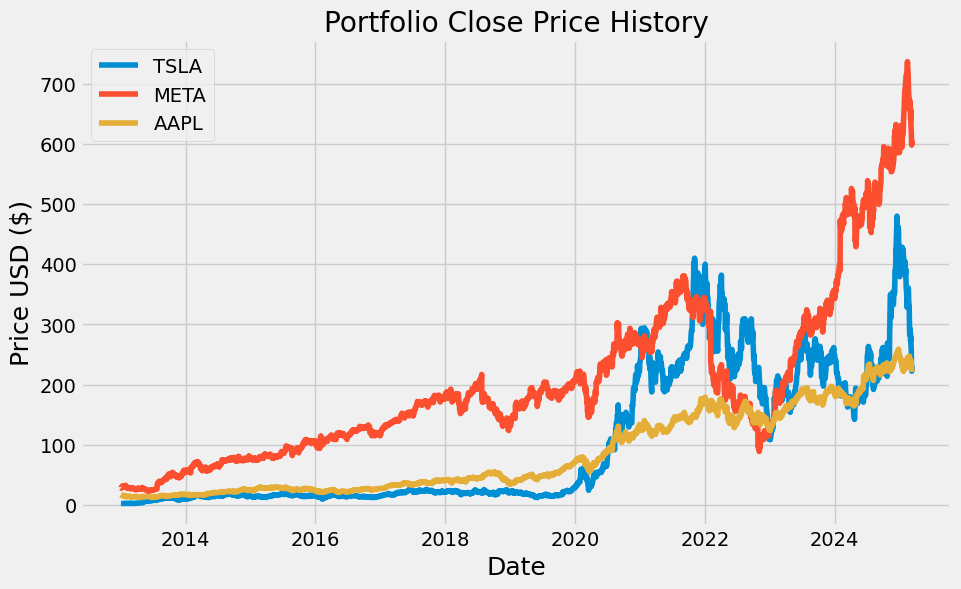

In [6]:
#Plot the close price history
title = "Portfolio Close Price History"
my_stocks = df

plt.figure(figsize=(10, 6))
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label=c)

plt.title(title)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

In [7]:
#show the daily simple return
returns = df.pct_change()
returns

,TSLA,META,AAPL
Date,,,
2013-01-02,NaN,NaN,NaN
2013-01-03,-0.016685,-0.008214,-0.012622
2013-01-04,-0.010642,0.035650,-0.027855
2013-01-07,-0.001744,0.022949,-0.005882
2013-01-08,-0.019220,-0.012237,0.002691
...,...,...,...
2025-03-05,0.025952,0.025734,-0.000805
2025-03-06,-0.056073,-0.043475,-0.001739
2025-03-07,-0.002961,-0.003615,0.015893


In [8]:
#create and show anualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,TSLA,META,AAPL
TSLA,0.332466,0.067027,0.059787
META,0.067027,0.144772,0.049132
AAPL,0.059787,0.049132,0.078255


In [9]:
#calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.13318772263218648

In [10]:
#Calculate the portfolio volitility
port_volatility = np.sqrt(port_variance)
port_volatility

0.36494893153999847

In [11]:
#calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.41170272799947405

In [12]:
#Show the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + '%'

print("Expected annual return: " + percent_ret)
print("Annual Volatility / risk: " + percent_vols)
print("Annual Variance: " + percent_var)

Expected annual return: 41.0%
Annual Volatility / risk: 36.0%
Annual Variance: 13.0%


In [13]:
#!pip install PyPortfolioOpt

In [14]:
#Portfolio Optimization

#Calculate expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#Optimize for max Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict({'TSLA': 0.23951, 'META': 0.27777, 'AAPL': 0.48272})
Expected annual return: 30.4%
Annual volatility: 29.1%
Sharpe Ratio: 1.05


(0.30385526005677294, 0.29050883586719595, 1.0459415430506156)

In [15]:
#Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights

# Ask the user for the total portfolio value
try:
    total_portfolio_value = float(input("Enter the amount of money you want to invest in your portfolio: $"))
except ValueError:
    print("Invalid input! Please enter a numeric value.")
    exit()

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Enter the amount of money you want to invest in your portfolio: $ 5000


Discrete allocation: {'TSLA': 5, 'META': 2, 'AAPL': 11}
Funds remaining: $206.44


In [16]:
#This code block adds optimization for sorintino ratio

# Set parameters
risk_free_rate = 0.01  # Adjust as per the current risk-free rate

# Define the Sortino Ratio calculation function
def sortino_ratio(weights, returns, risk_free_rate=0.01):
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    downside_returns = returns[returns < 0].fillna(0)  # Only consider negative returns
    downside_risk = np.sqrt(np.mean((downside_returns.dot(weights)) ** 2)) * np.sqrt(252)  # Annualized downside risk

    sortino = (portfolio_return - risk_free_rate) / downside_risk
    return -sortino  # Negative for minimization

# Constraints: weights sum to 1
def weight_constraint(weights):
    return np.sum(weights) - 1


# Convert the 'weights' OrderedDict to a list for optimization
initial_weights = list(weights.values())
# bounds should have the same length as initial_weights
bounds = [(0, 1) for _ in range(len(initial_weights))]


# Run the optimization
# Change: Pass initial_weights instead of weights to minimize
optimized_result = minimize(
    sortino_ratio,
    initial_weights,  # Pass the list of initial weights here
    args=(returns, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints={'type': 'eq', 'fun': weight_constraint}
)

# Extract optimized weights
optimized_weights = optimized_result.x
optimized_sortino = -optimized_result.fun  # Get positive Sortino Ratio

print("Optimized Portfolio Weights:", optimized_weights)
print("Maximized Sortino Ratio:", optimized_sortino)

Optimized Portfolio Weights: [0.34879408 0.29792003 0.35328589]
Maximized Sortino Ratio: 1.5896205661986502


In [17]:
#Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(df)

# Convert optimized_weights (NumPy array) to a dictionary
weights = dict(zip(df.columns, optimized_weights)) # df.columns provides the tickers

# Ask the user for the total portfolio value
try:
    total_portfolio_value = float(input("Enter the amount of money you want to invest in your portfolio: $"))
except ValueError:
    print("Invalid input! Please enter a numeric value.")
    exit()

# Pass optimized_weights to DiscreteAllocation
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Enter the amount of money you want to invest in your portfolio: $ 5000


Discrete allocation: {'TSLA': 8, 'META': 2, 'AAPL': 8}
Funds remaining: $177.22
